In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/nlp_liflow/

/content/drive/My Drive/nlp_liflow


In [3]:
!ls

자연어처리_1.ipynb		  item_all_방송_연예.csv
자연어처리_2.ipynb		  item_all_재테크.csv
all_df_with_tokens.csv		  item_all_직장.csv
all_sen.csv			  item_all_음식.csv
cc.ko.300.bin.gz		  item_all_건강.csv
data.csv			  item_all_스포프.csv
df_all				  item_all_스포츠.csv
df_all.csv			  item_all_자동차.csv
df_all_GloVe.csv		  item_all_다이어트.csv
df_all_tfidf.csv		  item_all_취미생활.csv
doc2vec_100.model		  item_all.csv
feature.pkl			  item_all_doc2vec_k-means.csv
feature.pkl.mtx			  item_all_GloVe_DBSCAN.csv
final_trainingset_자녀.csv	  item_all_glove_k-means.csv
final_trainingset_자동차.csv	  ko.bin
final_trainingset_sports.csv	  list_to_csv.csv
first_embedding_clustering.model  nlp_tokenizer.ipynb
glove_model_100.model		  스포츠_sen.csv
glove_model.model		  sen.csv
glove_word_dict_128.pickle	  sen_preprocessig.csv
item_1.csv			  스포츠_sen_prerprocessing.csv
item_all_자녀.csv		  sentence_Summarizer.ipynb
item_all_노후.csv		  textrank
item_all_국가_지역.csv		  textrank_

In [4]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-12-27 00:31:25--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-12-27 00:31:26--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7ae87e7a036c3d524fc7db9b3.dl.dropboxusercontent.com/cd/0/get/BzZ2EIRwokI1f0ECUVdbOjeZUXOreqtWWrIsNO9oQ8zgu7cv6CFVzbe6GbD019btLZ85-BsL4G3ZIi_ovHfQyE557rw0xkGYR2h7kraAYq41UnnldF5mNiFG-YW0IAhWpNTqx4RoVxTGgMciKCGOqGkNPtdKRJGHLxFPbbOC8TU1EL4AfJV4oEwp6rXhGOOZ_I0/file?dl=1# [following]
--2022-12-27 00:31:26--  https://ucb7ae87e7a036c3d524fc7db9b3.dl.dropboxusercontent.com/cd/0/get/BzZ2EIRwo

In [5]:
import re
import pandas as pd
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import gensim
import logging
import os
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from timeit import default_timer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from numpy import zeros, float32 as REAL, vstack, integer, dtype
import numpy as np
from gensim import utils, matutils  
from gensim.utils import deprecated
from gensim.models import Word2Vec 
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 원본파일 가져오기

In [7]:
files = pd.read_csv('data.csv')
files = files.loc[files['convrsThema']=="스포츠", "sentence"]
files

4037               어제 탁구 시합할 때 그 빽 서브 넣을 때 그렇게 연습을 안 하고 하니까
4038                                    그게 잘 들어가던데 빽 서브 넣는데
4039                                    그것도 연습을 좀 많이 해야겠더라고
4040                                 조금 하다 보니까 공이 막 뜨고 그러니까
4041                        상대방이 때리고 나니까 쫌 그것도 안 좋기는 안 좋더라고
                                ...                        
191045    나도 배드민턴 해봤지만 (NO:) 배드민턴 채 하나에 (SP:기) 기본적으로 최소 ...
191046      탄성이 다르거든 하다 보면 운동이라는 것이 (SP:욕심이라) 욕심이라는 것이 생기잖아
191047           아무튼 스포츠가 됐든 레저가 됐든 뭐든지 너무 과하게 (SP:하) 하다 보면
191183      왜 한국에 와서 그렇게 (SP:했) 했느냐고 물었을 때 그냥 고개를 돌렸다고 하더라고
191214          이름이 잘 알려진 메시보다 잘하니까 흔히 (SP:신) 신계라고 말하기는 하지만
Name: sentence, Length: 13904, dtype: object

In [8]:
mecab = Mecab()

def tokenizer(raw, pos=["NNG","NNP","VV","VA"]): 
  return [word for word, tag in mecab.pos(raw) if len(word) > 1 and tag in pos]

def duplicate_drop(df):
  df_a = df.apply(lambda a : tokenizer(a))
  df_a= df_a.drop_duplicates(keep='first')
  idx = df_a.index
  return df.loc[idx]

def preprocessing(sents):
  remain_pattern = re.compile(r'\([^)]*\)')
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

  ws_replace = re.sub(r'\xa0', r'', sents)
  text_rm = remain_pattern.sub(r'', ws_replace)
  text = hangul.sub(r'', text_rm)
      
  return text

def whitespace_drop(sents):
  sents = sents.replace(" ","")

  return sents

In [9]:
files = files.apply(lambda a : preprocessing(a))
files_wsd = files.apply(lambda a : whitespace_drop(a))
files_wsd = files_wsd.drop_duplicates(keep='first')
idx = files_wsd.index
files = files.loc[idx]
files = duplicate_drop(files)
files

4037       어제 탁구 시합할 때 그 빽 서브 넣을 때 그렇게 연습을 안 하고 하니까
4038                            그게 잘 들어가던데 빽 서브 넣는데
4039                            그것도 연습을 좀 많이 해야겠더라고
4040                         조금 하다 보니까 공이 막 뜨고 그러니까
4041                상대방이 때리고 나니까 쫌 그것도 안 좋기는 안 좋더라고
                            ...                    
191045    나도 배드민턴 해봤지만  배드민턴 채 하나에  기본적으로 최소 이십만원이야
191046       탄성이 다르거든 하다 보면 운동이라는 것이  욕심이라는 것이 생기잖아
191047         아무튼 스포츠가 됐든 레저가 됐든 뭐든지 너무 과하게  하다 보면
191183    왜 한국에 와서 그렇게  했느냐고 물었을 때 그냥 고개를 돌렸다고 하더라고
191214        이름이 잘 알려진 메시보다 잘하니까 흔히  신계라고 말하기는 하지만
Name: sentence, Length: 5036, dtype: object

# 전처리 파일 가져오기

In [6]:
files = pd.read_csv('item_all_스포츠.csv',index_col = 0)
files = files['convrs']
files

0                볼링은 그다지 돈이 많이 들어가는 운동도 아니고 둘이 가서 쳐도 되잖아
1             특히 남들이 자주 하는 당구 같이 공 가지고 노는 건 잘 못 하는 것 같아요
2                우리는 그나마 서울 가서 접하다 보니까  실내 운동을 자주 하게 되었지
3                                     아니 나도 마찬가지야 나도 똑같애
4                 그냥 골프를 더 하고 싶은데 돈 생각했을 때 볼링을 하자고 하는 거야
                              ...                       
3640       그렇게 사회 생활 하면서 다른 거에 돈 허투루 쓰지 않으면 충분히 괜찮을 것 같아
3641    보통 이제 잘 하는 사람만 키우고 못하는 사람은 신경 안 쓰는 약간 그런 부분이 있잖아
3642                  예전에는 그걸 보더라도 그런 자세한 부분이 보이지 않았었거든요
3643          홀이라고 하던데  홀에 나가서 골프를 치면 참 멋있어 보이고 운동도 된다든데
3644            내가 그렇게 했으면 다른 부분에서도 이렇게 했으면 좋았겠다  이러는 거고
Name: convrs, Length: 3519, dtype: object

# Doc2Vec

In [ ]:
#train, test 분리 (80/20)
files, test = train_test_split(files, test_size=0.2, shuffle=True, random_state=34)

In [ ]:
files

4156              사람들 이야기를 들어 보면 물 속에서 하는 운동이 관절에 좋다잖아
33      그때 주변에서 도와줘서 심장병 수술을 하면서 이제 그때부터 축구를 할 수 있던 거지
25        그런데 씽씽이는 되게 많이 위험하고 헬멧도 안 쓰고 그냥 차 사이로 막 다니니까
2457                선생님은 다시 한번 잡으시면 잘 하실 것 같은데 계획 없으세요
2553     그런데 뜻하지 않게 이렇게 볼 하나씩 주워서 가면은 굉장히 재미있고 추억으로 남아
                             ...                      
1412        잘 쳐야지  내가 원래 승부욕 얘기가 나왔으니까 말인데  승부욕이 엄청 많아
4612           땀이 약간 날 정도로 해야하는데  내가 다섯바퀴를 돌아도 땀이 안 나면
4334       어쨌든 그 속에서 모두가 즐겁고 행복한 그런 수영 대회가 아니었나 싶기도 하고
1400                   그리고 시간 될 때는 한 삼십 분 정도 스트레칭 해도 해
3893          탁구도 보면 옛날에 현정화 선수라든지  유남규 선수도 있고 많이들 있잖아
Name: convrs, Length: 2927, dtype: object

In [ ]:
test

1470      그런데 한화 이글스는 맨날 수비 실책이야 그래도 요새 임중석이가 잘하더라
1772              그러니까 항상 보호자 한명은 같이 횡단보도 중간에 서 있고
4809          한시간씩 혼자 걷기 운동하거든요 그렇게 걸으면 땀 나니까 샤워하고
3504         형제지간에 오래 살아야 돼 혼자 살아가면 사람 인생이 좀 슬플테니까
3780                     지금은 좀 나름대로 좀 많이 건강해진 것 같아
                           ...                    
298            나는 구번 이하를 도는 동안 백분에서 삼사십분은 놓치는 것 같아
1666     그러니까 금요일 날 꼭 참석해서 하자고 금요일은 조기 퇴근해서 네시면 끝나
3098       혼자서 할 수 있고 뭐 티브이 보면서 없어지는 시간을 활용할 수도 있고
519                     안정환이 뛸 때 안정환  응 그때 당시에 많이 
3911    나도 그에 대해서는 동감해 박항서가 선수 시절 부터 열심히 하지 않았나 싶어
Name: convrs, Length: 732, dtype: object

In [66]:
token = []
convrs = []
for i in files:
  convrs.append(i)
  token.append(tokenizer(i))

In [67]:
token

[['볼링', '들어가', '운동'],
 ['당구', '가지'],
 ['서울', '접하', '실내', '운동'],
 ['마찬가지', '똑같'],
 ['골프', '생각', '볼링'],
 ['승부', '볼링'],
 ['오늘', '재미있'],
 ['골프', '볼링', '생각', '볼링'],
 ['다양', '재미있'],
 ['친구', '배우'],
 ['볼링', '배우', '볼링', '들어가'],
 ['시간', '생각', '정도', '재미있'],
 ['시간', '스포츠'],
 ['볼링', '볼링', '그렇'],
 ['마찬가지', '보미', '배우'],
 ['대학교', '친구', '당구'],
 ['친구', '동창', '그러', '얘기'],
 ['취미', '나이', '볼링'],
 ['집중', '탁구'],
 ['친구', '직장', '당구'],
 ['스포츠', '옛날', '당구'],
 ['볼링'],
 ['구경', '탁구'],
 ['수업', '시간'],
 ['배우', '집중'],
 ['탁구', '재미', '친구'],
 ['골프', '볼링'],
 ['볼링', '분위기'],
 ['재미', '시간', '생각'],
 ['친구', '취미', '생활', '모르'],
 ['주말', '이용', '오후', '운동', '생각'],
 ['탁구', '얘기', '시간'],
 ['당구', '운동', '당구', '신경'],
 ['골프', '재미있', '다행', '운동'],
 ['수영', '사람', '재미있'],
 ['호흡', '재미있'],
 ['운동', '들어가', '마찬가지'],
 ['중계', '운동', '자극'],
 ['사람', '재미있'],
 ['얘기', '시간'],
 ['운동', '얘기', '구경'],
 ['골프', '얘기', '볼링'],
 ['승부', '얘기', '승부'],
 ['생각', '이수근', '중계', '탁구'],
 ['학교', '모르', '생각'],
 ['재미있', '골프', '관심'],
 ['운동', '들어가', '볼링', '마찬가지'],
 ['볼링', '만족', '생각'],
 ['

In [10]:
common_texts_and_tags = [
    (text, [f"convrs_{i}",]) for i, text in enumerate(token)
]
'''
for text, tags in common_texts_and_tags:
    print(f"tags: {tags}, text: {text}")
'''
TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]
docvecmodel = Doc2Vec(TRAIN_documents, vector_size=100, alpha = 0.025, epochs = 100, window=5, min_count=1, workers=4)

#모델 저장하기     
docvecmodel.save('doc2vec_100.model')

doc_vec_100 = pd.DataFrame(columns=['tag','text','trained_vector','convrs'])

# document의 vector를 구하는 방법은, 기 학습된 docvec을 가져오거나, 해당 단어를 넣고 다시 예측하는 것. 
for (text, tags),convrs in zip(common_texts_and_tags, convrs):
    trained_doc_vec = docvecmodel.docvecs[tags[0]]
    test_doc_vec = docvecmodel.infer_vector(text) #같은 문서를 모델에 다시 넣어서 옳게 임베딩을 진행했는지 확인해보기
    new_row = pd.DataFrame([[tags, text, trained_doc_vec, convrs]], columns = doc_vec_100.columns)
    doc_vec_100 = pd.concat([doc_vec_100, new_row], ignore_index = True)
    print(f"tags: {tags}, text: {text}")
    print(f"trained_doc_vec: {trained_doc_vec}")
    print(f"inferred_doc_vec: {test_doc_vec}")
    print("--"*20)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 -0.2452     -0.2669008   0.1743075  -0.11033884 -0.08901125 -0.03049489
 -0.13632731  0.2845024   0.21540189  0.14781271 -0.14467171  0.07554828
 -0.19224861 -0.3227503  -0.37010992  0.17110327 -0.00878693 -0.04516973
  0.33837438 -0.09859352  0.08056079 -0.01150581  0.3191039  -0.2027724
 -0.09270181  0.1800057  -0.16081817 -0.14467165 -0.03215533  0.02503353
 -0.12324646 -0.21023469  0.15024719  0.33491257  0.03353744 -0.02303063
  0.05136051 -0.02615492  0.01409516 -0.10065396 -0.15895815  0.21805717
 -0.01524559  0.2445782  -0.07720643 -0.40523496  0.5568451  -0.09741158
  0.05970198 -0.22442608  0.39361155 -0.02917913  0.20220244 -0.25345942
  0.24734683 -0.24077831 -0.07829798  0.24353996 -0.093696   -0.09696607
  0.0703039   0.28154358 -0.09295817  0.29558262 -0.2913984  -0.09600081
  0.00921486  0.3102867  -0.31731638 -0.20810854 -0.02040641 -0.15152912
 -0.00390439  0.4409025  -0.05969046  0.22862764  0.10661162 -0.1700219
  0.06715845 -0.0

In [11]:
doc_vec_100

,tag,text,trained_vector,convrs
0,[convrs_0],"[볼링, 들어가, 운동]","[-0.033883017, -0.040609833, -0.028049976, -0....",볼링은 그다지 돈이 많이 들어가는 운동도 아니고 둘이 가서 쳐도 되잖아
1,[convrs_1],"[당구, 가지]","[-0.02484926, 0.015763216, 0.0833806, -0.07544...",특히 남들이 자주 하는 당구 같이 공 가지고 노는 건 잘 못 하는 것 같아요
2,[convrs_2],"[서울, 접하, 실내, 운동]","[0.0077698804, -0.021236923, 0.054564092, -0.0...",우리는 그나마 서울 가서 접하다 보니까 실내 운동을 자주 하게 되었지
3,[convrs_3],"[마찬가지, 똑같]","[-0.04404351, -0.045692172, 0.060518973, -0.00...",아니 나도 마찬가지야 나도 똑같애
4,[convrs_4],"[골프, 생각, 볼링]","[-0.030440435, -0.049523205, -0.010295855, -0....",그냥 골프를 더 하고 싶은데 돈 생각했을 때 볼링을 하자고 하는 거야
...,...,...,...,...
3514,[convrs_3514],"[사회, 생활, 괜찮]","[-0.117450014, -0.043909602, -0.03379594, 0.05...",그렇게 사회 생활 하면서 다른 거에 돈 허투루 쓰지 않으면 충분히 괜찮을 것 같아
3515,[convrs_3515],"[보통, 사람, 키우, 사람, 신경, 부분]","[0.15611911, 0.110802606, -0.004813456, 0.0329...",보통 이제 잘 하는 사람만 키우고 못하는 사람은 신경 안 쓰는 약간 그런 부분이 있잖아
3516,[convrs_3516],"[예전, 부분, 보이]","[-0.06822475, -0.035221957, -0.039023653, 0.07...",예전에는 그걸 보더라도 그런 자세한 부분이 보이지 않았었거든요
3517,[convrs_3517],"[나가, 골프, 멋있, 보이, 운동]","[-0.07587912, -0.10613181, -0.06149061, 0.1022...",홀이라고 하던데 홀에 나가서 골프를 치면 참 멋있어 보이고 운동도 된다든데


# PCA

In [12]:
feature=[]
for i in range(0,15):
    a = "feature"+str(i)
    feature.append(a)
# 1500 개의 주성분으로 차원 축소
pca = PCA(n_components=15) 
printcipalComponents = pca.fit_transform(docvecmodel.docvecs.vectors_docs)

principalDf = pd.DataFrame(data=printcipalComponents, columns = feature)
print(sum(pca.explained_variance_ratio_))

0.8969066366553307


In [13]:
principalDf

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14
0,-0.168602,-0.380102,0.133984,0.010240,-0.020988,0.045380,-0.083407,-0.127876,0.204948,0.236015,0.085670,0.041894,-0.040021,0.124188,0.087395
1,-0.132267,-0.334509,0.392848,0.040089,0.086899,0.072718,-0.089849,0.118833,0.118423,-0.091650,0.198752,0.065072,-0.050136,0.085153,0.059696
2,0.024740,-0.006160,0.330554,-0.060712,0.068811,-0.001244,-0.080235,0.039160,0.135999,0.062211,0.054300,0.008826,-0.012160,-0.027072,0.023395
3,-0.035559,-0.197192,0.147380,0.046513,-0.040157,0.051554,-0.072045,-0.057992,0.095843,0.143537,0.100100,0.052586,-0.100146,0.080420,0.062363
4,-0.156255,-0.393246,0.356526,-0.214427,-0.079519,-0.060370,-0.061274,-0.144630,0.250467,0.187518,-0.029234,0.099070,-0.000396,0.073672,0.028519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,-0.251705,-0.366759,0.086832,-0.250394,-0.425105,0.509371,-0.022605,-0.202720,-0.028244,-0.078087,-0.082503,0.453528,-0.123498,0.183341,0.032701
3515,-0.179930,-0.675078,-0.077857,-0.022770,0.282345,0.065218,-0.384476,-0.129354,-0.148337,0.241336,-0.143908,0.066805,0.148935,-0.212033,-0.115847
3516,-0.007171,-0.436735,-0.031789,-0.225442,-0.066436,0.247089,-0.264897,-0.124321,0.083876,0.397761,-0.272897,-0.331171,0.032187,-0.181669,0.097005
3517,-0.297834,-0.630404,-0.238366,-0.201689,-0.243756,-0.358222,0.112316,0.026717,-0.170214,0.254569,-0.375646,-0.191394,-0.022727,-0.129808,0.351553


# TSNE

In [ ]:
# 2차원으로 축소
n_components = 2

# t-SNE 모델 생성
tsne = TSNE(n_components = n_components)

# 학습한 결과 2차원 공간값 출력
tsnedata = tsne.fit_transform(docvecmodel.docvecs.vectors_docs)

print(tsnedata)
column = ['x', 'y']
tsnedata = pd.DataFrame(tsnedata, columns = column)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-65.68108    13.723698 ]
 [ 67.30102    -2.8169134]
 [-37.100292  -23.150764 ]
 ...
 [-14.970338   14.003075 ]
 [-37.860195    7.897505 ]
 [ 28.544538   -3.3285756]]


# DF 정의


In [ ]:
df = pd.DataFrame(columns = [str(i) for i in range(100)])
for i in doc_vec_100['trained_vector']:
  df = df.append(pd.Series(i, index=df.columns), ignore_index=True)  #100차원 값

In [ ]:
df = tsnedata #pca -> 2차원 축소 값

In [14]:
df = principalDf #pca n차원 축소 값

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()
dbscan = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
# create model and prediction
dbscanmodel = DBSCAN(eps=0.3, min_samples= 5)#적어도 5의 샘플이 모여야 한 군집으로
dbscanmodel.fit(dbscan)
doc_vec_100['cluster'] = dbscanmodel.fit_predict(dbscan)
result = dbscanmodel.fit_predict(dbscan)
doc_vec_100

,tag,text,trained_vector,convrs,cluster
0,[convrs_0],"[수영, 마이산, 등산]","[0.1653082, 0.10958114, -0.079088986, -0.03524...",수영 끝나고 마이산을 한번 같이 등산하러 가보자고,-1
1,[convrs_1],"[실내, 게임, 생각, 변화, 얘기]","[0.18045685, 0.0550259, -0.106633924, -0.09032...",같은 실내 게임처럼 우리가 생각하는 게 변화가 되고 있다는 얘기지,-1
2,[convrs_2],"[다니, 사람, 다니, 얘기]","[0.11662559, 0.055082224, 0.047172364, -0.0327...",같이 다니는 사람들이 길게 보고 다니라고 그런 얘기를 하더라고,-1
3,[convrs_3],"[건강, 느낌]","[0.078119636, 0.081583165, -0.06546769, -0.064...",것 같고 벌써 건강해진 느낌이 들어,-1
4,[convrs_4],"[경험, 스포츠, 기억]","[0.09372773, 0.016877063, -0.1424199, -0.06613...",경험했던 스포츠 중에 제일 기억에 남는 것이 있니,-1
...,...,...,...,...,...
3654,[convrs_3654],"[휴일, 시간, 시간, 가정, 등한시]","[0.09517644, 0.13484032, -0.025526356, -0.0999...",휴일에 시간 날 때 시간을 온통 거기에 쏟아부어야 되니까 가정을 좀 등한시하겠지,-1
3655,[convrs_3655],"[휴일, 얘기, 기억, 꺼내]","[0.20471227, 0.0980326, -0.03324793, -0.091038...",휴일에 대해서 얘기를 하는 것이 기억 속에서 꺼내며 말할 수 있어서 참 좋다,-1
3656,[convrs_3656],"[희노애락, 프로, 야구, 기여]","[-0.034825448, 0.13837552, -0.3587115, -0.0010...",희노애락을 딱 갖는 거기에서 이제 프로야구가 상당히 우리에게 기여를 했다고 봐야죠,-1
3657,[convrs_3657],"[히딩크, 감독, 체력, 키우, 지구력]","[-0.036557678, 0.024886828, 0.12324259, 0.0488...",히딩크 감독 밑에 배워서 가지고 그냥 체력 키우고 지구력 키워서 나간 거였어,-1


In [ ]:
count = 0
for cluster_num in set(result):
    # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
    if(cluster_num == -1 or cluster_num == 0): 
        continue
    else:
        print("cluster num : {}".format(cluster_num))
        temp_df = doc_vec_100[doc_vec_100['cluster'] == cluster_num] # cluster num 별로 조회
        for title in temp_df['convrs']:
            print(title) 
            count+=1
        print()

print(count)


cluster num : 1
왜냐하면 탁구를 이렇게 치면은 치매도 좋다고 하고 뭐든게 다 좋다고
그렇게 해서 그냥 탁구를 못 치는데 그냥 계속 칠라고
시골에 가서 일도 좀 하고 주중에는 탁구도 치고 하는 게 좋은 거 같애
그 볼은 받으려면 그런데 탁구는 그래도 그 반경이 좀 좁잖아
나는 운동을 안 해 봤지만 안 해 보고 탁구를 배웠거든
우리 탁구 치는 날까지 그래 우리는 우정을 변치말자
다 탁구가 좋아서 모이고 하는 거라 다 사람들이 다 순하고 좋은 거 같애
나는 이게 탁구를 못 쳐서 자신감이 없어
다들 바쁘겠지 그렇지만 그래도 탁구가 좋아서 오는 사람들이잖아
탁구는 이게 좁은 공간에서 그걸 넣는다는게 힘든 거 같아 내가 보니까
나도 이렇게 테레비나 이렇게 탁구 저기한 사람들 이렇게 봤어
다들 바쁘겠지 바쁘겠지만 그래도 탁구가 좋아서 오는 사람들이 잖아
나도 이렇게 텔레비나 이렇게 탁구 저기한 사람들 이렇게 봤어
집에서 심심하면 우리 탁구나 한번 칠까 나가서 탁구 한번 치면 몸두 개운하고
내가 계속 바쁘다고  창피할까 봐 안 가는 거야  
 하는 것보다는 구경하는 쪽을 많이 하고 탁구도 많이 쳤던 거 같아요
우리  탁구장이 있거든 가서 가족들이랑 탁구를 많이 치거든
직접적으로    탁구도 많이 쳤던 거 같아요
아까 탁구 얘기를 했는데  사실 탁구가 굉장히 전신에 좋은 운동이거든
나도 사십대 중반까지는 탁구를 치다가 안 쳤는데  다시 라켓을 샀어
근데 라켓을 샀는데도 남는 시간이 없어서 탁구를 안 치게 되더라고
그래서 나는 탁구 같은 운동도 전신운동이니까  한번씩 해도 될 것 같아
탁구는 가벼운 운동이니까  또 우리가 탁구를 제법 잘 하는 편에 속하잖아
탁구도 그냥 전신 운동 한다고 생각하면  가벼운 운동이 돼서 좋을 것 같아
나도 사십대 중반까지는 타구를 치다가 안 쳤는데  다시 라켓을 샀어
탁구로 예를 들자면 생각보다 탁구도 돈이 많이 들거든 한달에 십만원 정도래

cluster num : 2
그런데 뭐 처음부터 잘하는 사람은 없을 꺼 같애 그지
매일 서로 

In [ ]:
from sklearn import metrics
n_cluster = len(set(dbscanmodel.labels_))-(1 if -1 in dbscanmodel.labels_ else 0)
n_noise = list(dbscanmodel.labels_).count(-1)

print("클러스터 개수 : ", n_cluster)
print("노이즈 개수 : ", n_noise)
print("실루엣계수 : %.3f" %  metrics.silhouette_score(df, dbscanmodel.labels_, metric = 'euclidean'))
#print("completeness : %.3f" %  metrics.completeness_score(y, dbscanmodel.labels_))


클러스터 개수 :  18
노이즈 개수 :  3033
실루엣계수 : -0.213


# k-means

In [ ]:
df = tsnedata #2차원 축소 값
doc_vec_100['tsne_x'] = tsnedata['x']
doc_vec_100['tsne_y'] = tsnedata['y']

In [131]:
from sklearn import preprocessing
df = principalDf #pca n차원 축소 값
print("##"*30)
print("K-Means Clustering")
print("##"*30)
# 시도해 볼 cluster 수
cluster_number = range(5,101)
distortions = []
processed_data = doc_vec_100.copy()
scaler = preprocessing.MinMaxScaler()
#scaler.fit_transform(docvecmodel.docvecs.vectors_docs)
scaler.fit_transform(df)

# 모델 학습
for k in cluster_number:
    Clustering_Method = KMeans(n_clusters=k, random_state = 0)
    #X = model.docvecs.vectors_docs 
    #Clustering_Method.fit(docvecmodel.docvecs.vectors_docs)
    Clustering_Method.fit(df)
    distortions.append(Clustering_Method.inertia_)
    
# Elbow Curve 시각화
fig = plt.figure(figsize=(15, 5))
plt.plot(cluster_number, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

############################################################
K-Means Clustering
############################################################


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

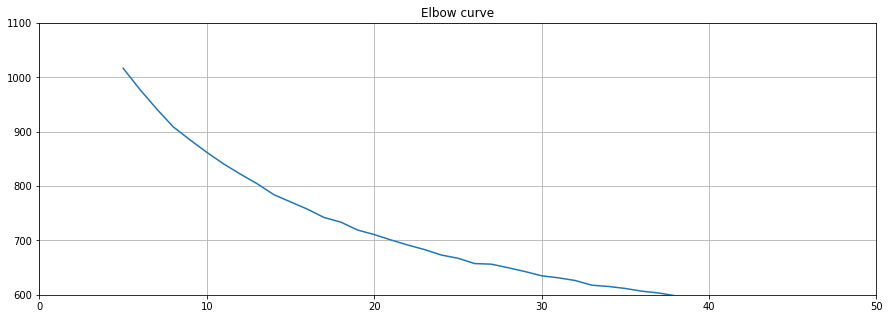

In [128]:
fig = plt.figure(figsize=(15, 5))
plt.plot(cluster_number, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlim(0,50)
plt.ylim(600,1100)
plt.show()

In [ ]:
Clustering_Method.labels_

array([7, 2, 1, ..., 1, 1, 5], dtype=int32)

In [15]:
from math import*
def euclidean_distance(x, y):
    return sqrt(sum(pow(a - b, 2) for a, b in zip(x, y)))

In [16]:
from sklearn import preprocessing
Clustering_Method = KMeans(n_clusters=15, random_state=0)
X = principalDf # document vector 전체를 가져옴.  

# 전체 말고 줄인 dim 으로 진행하기 

scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(X)
x_std = scaler.transform(X)
Clustering_Method.fit(X)# fitting 
count = 0
#Clustering_Method.cluster_centers_
cluster_dict = {i:[] for i in range(0, 15)}
for text, label in zip(range(len(doc_vec_100)), Clustering_Method.labels_):
    a = []
    a.append(doc_vec_100['convrs'].loc[text])
    a.append([doc_vec_100['text'].loc[text]])
    a.append([doc_vec_100['trained_vector'].loc[text]])
    #a.append([doc_vec_100['tsne_x'].loc[text],doc_vec_100['tsne_y'].loc[text]])
    cluster_dict[label].append(a)
    

item_all_doc2vec = pd.DataFrame(columns = ['cluster','convrs','vec','distance','token'])
for (label, lst), y in zip(cluster_dict.items(),Clustering_Method.cluster_centers_):
    item = pd.DataFrame(columns = ['cluster','convrs','vec','distance','token'])
    print(f"Cluster {label}")
    for x in lst:
          token = str(x[1][0])
          vec = str(x[2][0])
          #print(x[2])
          #print(y)
          print(x[0])
          distance = euclidean_distance(x[2][0],y)
          new_df = pd.DataFrame({'cluster':label,
                                'vec': vec,
                                'token': token,
                                'convrs':x[0],
                                'distance': distance},index = [0])
          count+=1
          item = pd.concat([item,new_df], ignore_index = True)
    item = item.sort_values('distance')
    item_all_doc2vec = pd.concat([item_all_doc2vec, item], ignore_index = True)
    print("--"*30)
print(count)
print("##"*20)

Cluster 0
그 친구가 열심히 치고 있는데 나보고도 배우라고 권했거든
그래도 나는 당신이 좀 더 시간을 두고 다른 스포츠를 했으면 좋겠어
자기 친구나 동창들도 많이 친다면서 그러면 자기가 친다고 얘기를 해 봐요
이게 집중해서 해야 하고 또 탁구는 그런 거 같애
 하는 것보다는 구경하는 쪽을 많이 하고 탁구도 많이 쳤던 거 같아요
지금 새로운 걸 배우는 것 보다 지금 하고 있는 것에 집중하는 게 더 좋지 않을까
탁구 치는 게 재미는 있더라고 왜냐하면 친구도 만날수 있잖아
 재미는 있는데 내가 지금 이 시간에 왜  있나 이런 생각이 조금 들어
그 친구들도 없고 나밖에 없으니까  취미생활을 해 봐야 쓸만한가 모르겠네
탁구에 대해서도 얘기하고 하다 보면 시간이 잘가거든
몇 명이서 어디로 갔었는지 누가 이겼는지 얘기하는 데만 서너시간 걸려요
지금은 잠깐 끊었어 그런데  운동은 아까도 얘기했지만  구경하는 걸 좋아했는데
생각보다 이수근이 정말 잘 치더라 나도 중계 끝나고 탁구 한번 쳐야지
이게 하나의 작은 스포츠가 아니라 정말 어마어마한 의미를 가지고 있다고 생각하거든
또 애만 혼자 보내기도 조금 그렇더라고 나도 해야 된다고 맨날 얘기했고
그래 아크로바틱 수영장에서 그 하는 거 구경 했는데 운동이 많이 되겠더라고
혹시 지금이나 앞으로도 배우고 싶다거나 아니면 경험하고 싶은 것이 있어
웃고 즐기는 게 나는 좋을 것 같은디 친구는 워낙 잘 치니까 그게 재미없겠지
그래  나중에 한번 따라가 보든가 할게 가서 구경 하는 것도 재미있겠다
또 운동이라는 게  잘해야 재밌지 못 하면 재미가 없어서 할 수가 없어요
 그런 것도 운동 하면은 재밌기는 하지 일단 우리는 지금 너 쉬고 있을 때 정해야지
옛날에 내 친구 한명이랑은 산에 가는 스타일이 정말 잘 맞았어
나한테 자꾸 배우라고 하니까 친구는 기분이 나쁜지 같이 가자고 안 해
오늘 이렇게 대화를 나누어 보니까  스포츠에 대한 관점이나
내가 내일 모레 퇴직인데 그때는 같이 할 수 있는 스포츠를 배우면 좋겠어
그런데 구경하는 거는 

In [19]:
# CLustering 알고리즘의 성능 평가 측도
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score
from sklearn.metrics.cluster import contingency_matrix

from sklearn.preprocessing import StandardScaler  # 변수 표준화
from sklearn import metrics

#print('contingency_matrix\n' , contingency_matrix(y, Clustering_Method.labels_))
print('Silhouette Coefficient: %.3f' % silhouette_score(x_std, Clustering_Method.labels_, sample_size=1000))
print('Calinski and Harabasz score: %.3f' % calinski_harabasz_score(x_std, Clustering_Method.labels_))

#print("Homogeneity: %0.3f" % homogeneity_score(y, Clustering_Method.labels_))
#print("Completeness: %0.3f" % completeness_score(y, Clustering_Method.labels_))
#print("V-measure: %0.3f" % v_measure_score(y, Clustering_Method.labels_))
#print("Rand-Index: %0.3f" % rand_score(y, Clustering_Method.labels_))
#print("Adjusted Rand-Index: %.3f" % adjusted_rand_score(y, Clustering_Method.labels_))

Silhouette Coefficient: 0.020
Calinski and Harabasz score: 122.103


# 계층적 군집화

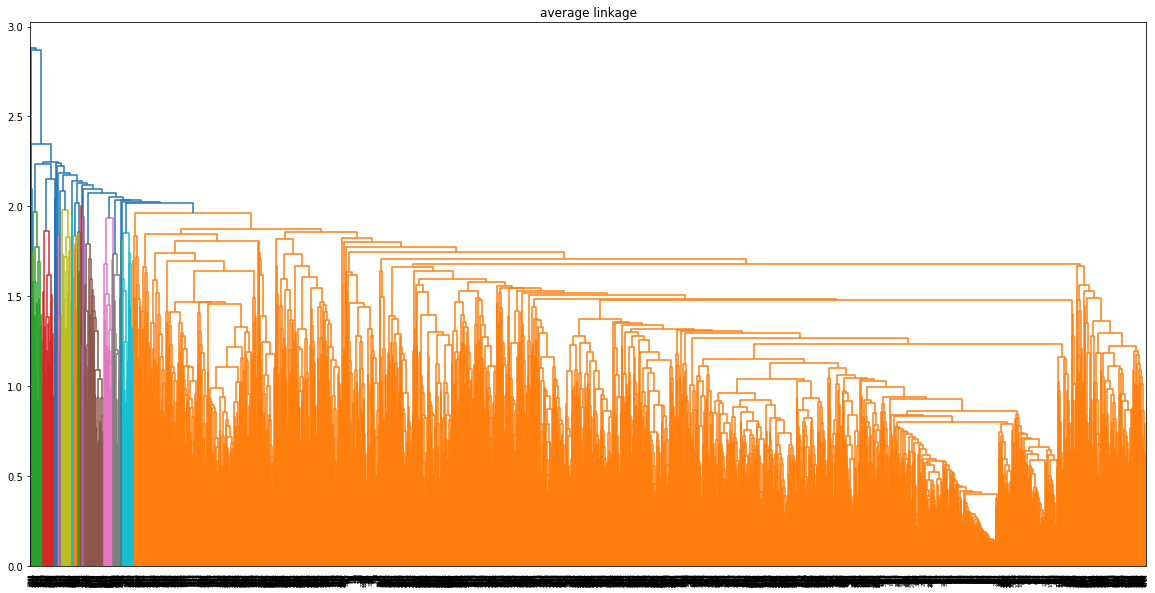

In [88]:
from scipy.cluster.hierarchy import dendrogram, linkage

scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(docvecmodel.docvecs.vectors_docs)
x_std = scaler.transform(docvecmodel.docvecs.vectors_docs)

fig = plt.figure(figsize=(20,10))
linked = linkage(x_std, 'average')
dendrogram(linked)
plt.title('average linkage')
plt.show()  

In [95]:
from scipy.cluster.hierarchy import fcluster
cut_tree = fcluster(linked, t = 2.2, criterion = 'distance')
labels = item_all_doc2vec['convrs']
distance = item_all_doc2vec['distance']
plt.figure(figsize=(40,20))
df = pd.DataFrame({'cluster':cut_tree, 'labels':labels, 'distance' : distance})

<Figure size 2880x1440 with 0 Axes>

In [96]:
metrics.silhouette_score(x_std, df['cluster'])

0.16316263

In [97]:
df =df.sort_values('cluster')
df

,cluster,labels,distance
225,1,탁구가 나이 먹어서는 할 수 있는 운동 중에 그래도 제일 괜찮은 것 같애,0.481283
2522,1,그런데 여기는 동원된 인원도 많이 없더라고 보니까 저기 있는 정도가 다,0.402912
215,1,그라고 탁구 치는 사람들이 다 마음이 좋은 거 같어,0.476725
2531,1,나한테 자꾸 그러거든 사고 나기 전에도 나랑 수성못 한바퀴 돌자더라고,0.404572
1656,2,걔가 십 오분만 뛰어 준다고 얘기를 하나 봐 이것도 한번 자세히 봐야 될 것 같아,0.276175
...,...,...,...
1164,5,우리나라가 힘이 없으니까 선수들에게도 차별받는 무시당한 느낌도 들었어,0.795452
3518,5,우리는 프로가 아니니까 이 지지대가 여기 저기 움직이기 되는 것 같아요,0.877933
1945,6,치다가 결국에는 진짜 무게에 못 이겨서 같이 빨려 들어간 적도 있어,0.835532
1672,7,거기 나이 좀 많이 드신 분들도 면허증 있는 사람들은 탈 수 있기는 하겠다,0.293996


# 데이터 셋

In [17]:
item_all_doc2vec

,cluster,convrs,vec,distance,token
0,0,어떤 사람은 집중을 많이 해 갖고 하고 그래서 나는 에이스로 가면 긴장돼,[ 0.05439183 -0.08446948 0.03726861 -0.010503...,0.315961,"['사람', '집중', '에이스', '긴장']"
1,0,그 어느 한계에 딱 부딪혀서 그걸 더 이상 넘지 못 하고 포기한 것 같아요,[-0.02033109 -0.08415344 0.08706608 -0.046135...,0.319713,"['한계', '이상', '포기']"
2,0,보니까 다른 스포츠하고 다르게 이상하게 정이 드는 거 같애,[-0.03806109 -0.0659163 0.10867666 -0.036701...,0.321373,"['스포츠', '다르', '이상']"
3,0,우리가 선수로 뛰는 건 아니니까 너무 큰 욕심 부리지 않고 배우는 게 좋아,[ 0.00274765 -0.11264477 0.09017026 0.018940...,0.322964,"['선수', '욕심', '부리', '배우']"
4,0,수영 배우는 것이 진짜 힘들더라고 어떤 사람이 물어보는 거야,[ 0.00944621 -0.1116652 0.02273126 0.035442...,0.323775,"['수영', '배우', '힘들', '사람']"
...,...,...,...,...,...
3514,14,배구 농구 축구 탁구 잘하지는 못했는데 그럭저럭 어느 정도는 할 만큼 했어,[-1.45653307e-01 5.32135814e-02 7.86051452e-...,0.890654,"['배구', '농구', '축구', '탁구', '정도']"
3515,14,요새 손흥민 중계에 잘 안 나오더라 연봉은 어떻게 잘 올라갔나 모르겠다,[-0.02275564 0.08096252 0.03200424 0.069746...,0.892723,"['손흥민', '중계', '나오', '연봉', '모르']"
3516,14,그 선수가 예전에 티비에 축구 가르치는 프로그램 거기에 나왔었더라고,[-0.12102904 0.10928689 -0.00813945 0.013614...,0.896655,"['선수', '예전', '티비', '축구', '가르치', '프로그램']"
3517,14,그래도 우리나라는 아직도 축구하면 차범근이랑 박지성 그리고 손흥민이지,[-0.07447763 0.11963847 0.06879354 0.074622...,0.896801,"['나라', '축구', '차범근', '박지성', '손흥민']"


In [18]:
item_all_doc2vec.drop(item_all_doc2vec[item_all_doc2vec['distance']>1.0].index, inplace = True)

In [19]:
item_all_doc2vec

,cluster,convrs,vec,distance,token
0,0,어떤 사람은 집중을 많이 해 갖고 하고 그래서 나는 에이스로 가면 긴장돼,[ 0.05439183 -0.08446948 0.03726861 -0.010503...,0.315961,"['사람', '집중', '에이스', '긴장']"
1,0,그 어느 한계에 딱 부딪혀서 그걸 더 이상 넘지 못 하고 포기한 것 같아요,[-0.02033109 -0.08415344 0.08706608 -0.046135...,0.319713,"['한계', '이상', '포기']"
2,0,보니까 다른 스포츠하고 다르게 이상하게 정이 드는 거 같애,[-0.03806109 -0.0659163 0.10867666 -0.036701...,0.321373,"['스포츠', '다르', '이상']"
3,0,우리가 선수로 뛰는 건 아니니까 너무 큰 욕심 부리지 않고 배우는 게 좋아,[ 0.00274765 -0.11264477 0.09017026 0.018940...,0.322964,"['선수', '욕심', '부리', '배우']"
4,0,수영 배우는 것이 진짜 힘들더라고 어떤 사람이 물어보는 거야,[ 0.00944621 -0.1116652 0.02273126 0.035442...,0.323775,"['수영', '배우', '힘들', '사람']"
...,...,...,...,...,...
3514,14,배구 농구 축구 탁구 잘하지는 못했는데 그럭저럭 어느 정도는 할 만큼 했어,[-1.45653307e-01 5.32135814e-02 7.86051452e-...,0.890654,"['배구', '농구', '축구', '탁구', '정도']"
3515,14,요새 손흥민 중계에 잘 안 나오더라 연봉은 어떻게 잘 올라갔나 모르겠다,[-0.02275564 0.08096252 0.03200424 0.069746...,0.892723,"['손흥민', '중계', '나오', '연봉', '모르']"
3516,14,그 선수가 예전에 티비에 축구 가르치는 프로그램 거기에 나왔었더라고,[-0.12102904 0.10928689 -0.00813945 0.013614...,0.896655,"['선수', '예전', '티비', '축구', '가르치', '프로그램']"
3517,14,그래도 우리나라는 아직도 축구하면 차범근이랑 박지성 그리고 손흥민이지,[-0.07447763 0.11963847 0.06879354 0.074622...,0.896801,"['나라', '축구', '차범근', '박지성', '손흥민']"


# 군집 시각화

In [ ]:
import matplotlib.pyplot as plt

# class target 정보 불러오기 
tsnedata['target'] = Clustering_Method.labels_

# target 별 분리
tsne_df_0 = tsnedata[tsnedata['target'] == 0]
tsne_df_1 = tsnedata[tsnedata['target'] == 1]
tsne_df_2 = tsnedata[tsnedata['target'] == 2]
tsne_df_3 = tsnedata[tsnedata['target'] == 3]
tsne_df_4 = tsnedata[tsnedata['target'] == 4]
tsne_df_5 = tsnedata[tsnedata['target'] == 5]
tsne_df_6 = tsnedata[tsnedata['target'] == 6]
tsne_df_7 = tsnedata[tsnedata['target'] == 7]
tsne_df_8 = tsnedata[tsnedata['target'] == 8]
tsne_df_9 = tsnedata[tsnedata['target'] == 9]


# target 별 시각화
plt.scatter(tsne_df_0['x'], tsne_df_0['y'], color = 'red', label = '0')
plt.scatter(tsne_df_1['x'], tsne_df_1['y'], color = 'orange', label = '1')
plt.scatter(tsne_df_2['x'], tsne_df_2['y'], color = 'yellow', label = '2')
plt.scatter(tsne_df_3['x'], tsne_df_3['y'], color = 'green', label = '3')
plt.scatter(tsne_df_4['x'], tsne_df_4['y'], color = 'blue', label = '4')
plt.scatter(tsne_df_5['x'], tsne_df_5['y'], color = 'navy', label = '5')
plt.scatter(tsne_df_6['x'], tsne_df_6['y'], color = 'pink', label = '6')
plt.scatter(tsne_df_7['x'], tsne_df_7['y'], color = 'purple', label = '7')
plt.scatter(tsne_df_8['x'], tsne_df_8['y'], color = 'grey', label = '8')
plt.scatter(tsne_df_9['x'], tsne_df_9['y'], color = 'black', label = '9')


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

NameError: ignored

# 군집 확인

In [20]:
Clustering_Method.cluster_centers_

array([[-9.04647708e-02, -3.03173155e-01,  1.19509585e-01,
        -6.30666539e-02,  1.05829788e-02, -1.11891061e-01,
         1.96271464e-02,  3.65447183e-03, -1.42370583e-02,
        -1.93008259e-02, -5.48653901e-02, -1.25536537e-02,
         1.97130814e-02, -2.42895950e-02,  1.15020117e-02],
       [-1.96376339e-01,  1.99908093e-02,  3.29162963e-02,
         4.57800686e-01,  2.58695669e-02, -3.06598973e-02,
         2.28278145e-01, -8.66240487e-02,  6.81011193e-03,
         1.86632890e-02,  7.42876902e-02,  2.56517865e-02,
         9.72652659e-02, -4.01309617e-02, -1.40410010e-02],
       [ 6.52330458e-01,  1.43135160e-01, -2.15099737e-01,
        -9.60180685e-02, -1.36860311e-01, -1.67090725e-02,
         1.03996702e-01,  4.89698909e-02,  3.33206058e-02,
         2.54857764e-02,  4.14387472e-02,  2.14170478e-02,
        -1.28581887e-02, -1.28840553e-02,  7.60633685e-03],
       [-4.91193891e-01,  1.10521391e-01, -3.30944747e-01,
        -1.03195809e-01,  2.08938450e-01,  1.08030178

In [21]:
dis_centroid = []
dis = []
cluster_num = [i for i in range(15)]
cen = []
for numi, i in zip(cluster_num, Clustering_Method.cluster_centers_):
  for numj, j in zip(cluster_num,Clustering_Method.cluster_centers_):
    distance = euclidean_distance(i,j)
    if distance < 0.4:
      print(numi, numj)
    dis.append(distance)
  dis_centroid.append(dis)
  dis = []
df = pd.DataFrame(dis_centroid)
df

0 0
1 1
2 2
3 3
4 4
5 5
5 11
6 6
7 7
8 8
8 11
9 9
10 10
11 5
11 8
11 11
12 12
13 13
14 14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.692758,0.959092,0.799178,0.589180,0.832094,0.875557,0.645512,0.630052,0.777619,0.406533,0.473680,0.563259,0.479064,0.661155
1,0.692758,0.000000,1.085996,0.833710,0.923805,0.804690,1.131597,0.744806,0.634653,0.863835,0.589151,0.626258,0.790334,0.825382,0.950772
2,0.959092,1.085996,0.000000,1.217952,0.829166,0.687498,0.816353,1.150351,0.926580,0.623959,1.097095,0.670888,0.863852,1.140910,0.573393
3,0.799178,0.833710,1.217952,0.000000,1.135735,0.937402,1.137277,0.729918,0.551527,1.104546,0.516965,0.765306,0.734753,1.002095,1.018896
4,0.589180,0.923805,0.829166,1.135735,0.000000,0.904369,0.909287,0.938316,0.923726,0.623322,0.862779,0.632729,0.829682,0.696551,0.639435
5,0.832094,0.804690,0.687498,0.937402,0.904369,0.000000,0.924915,0.897376,0.457529,0.735788,0.829651,0.369671,0.792516,0.919506,0.940976
6,0.875557,1.131597,0.816353,1.137277,0.909287,0.924915,0.000000,1.207203,0.999815,0.811382,1.056971,0.794350,0.960068,1.089739,0.785941
7,0.645512,0.744806,1.150351,0.729918,0.938316,0.897376,1.207203,0.000000,0.594829,1.014439,0.484122,0.670477,0.632013,0.756782,0.936954
8,0.630052,0.634653,0.926580,0.551527,0.923726,0.457529,0.999815,0.594829,0.000000,0.862487,0.440617,0.358157,0.585640,0.768877,0.913734
9,0.777619,0.863835,0.623959,1.104546,0.623322,0.735788,0.811382,1.014439,0.862487,0.000000,0.930821,0.590227,0.766763,0.958447,0.641844


In [25]:
cen = []
for i in range(15):
  cen.append((Clustering_Method.cluster_centers_[5][i] + Clustering_Method.cluster_centers_[8][i]+ Clustering_Method.cluster_centers_[11][i])/3)

cen = np.array(cen) 

In [26]:
centroid = []
for i in range(15):
  if i == 5:
    centroid.append(cen)
  elif i==8 or i==11:
    pass
  else:
    centroid.append(Clustering_Method.cluster_centers_[i])

In [27]:
centroid

[array([-0.09046477, -0.30317315,  0.11950959, -0.06306665,  0.01058298,
        -0.11189106,  0.01962715,  0.00365447, -0.01423706, -0.01930083,
        -0.05486539, -0.01255365,  0.01971308, -0.02428959,  0.01150201],
       dtype=float32),
 array([-0.19637634,  0.01999081,  0.0329163 ,  0.4578007 ,  0.02586957,
        -0.0306599 ,  0.22827815, -0.08662405,  0.00681011,  0.01866329,
         0.07428769,  0.02565179,  0.09726527, -0.04013096, -0.014041  ],
       dtype=float32),
 array([ 0.65233046,  0.14313516, -0.21509974, -0.09601807, -0.13686031,
        -0.01670907,  0.1039967 ,  0.04896989,  0.03332061,  0.02548578,
         0.04143875,  0.02141705, -0.01285819, -0.01288406,  0.00760634],
       dtype=float32),
 array([-0.4911939 ,  0.11052139, -0.33094475, -0.10319581,  0.20893845,
         0.10803018, -0.02104287,  0.02810173,  0.0780355 , -0.0027482 ,
        -0.02894575,  0.03017573,  0.02663952,  0.00804482,  0.02140371],
       dtype=float32),
 array([ 0.34350103, -0.3840

In [28]:
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 8), 'cluster'] = 5
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 11), 'cluster'] = 5

In [30]:
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 9), 'cluster'] = 8
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 10), 'cluster'] = 9
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 12), 'cluster'] = 10
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 13), 'cluster'] = 11
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 14), 'cluster'] = 12

In [31]:
np.unique(item_all_doc2vec.cluster)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype=object)

In [32]:
item_all_doc2vec

,cluster,convrs,vec,distance,token
0,0,어떤 사람은 집중을 많이 해 갖고 하고 그래서 나는 에이스로 가면 긴장돼,[ 0.05439183 -0.08446948 0.03726861 -0.010503...,0.315961,"['사람', '집중', '에이스', '긴장']"
1,0,그 어느 한계에 딱 부딪혀서 그걸 더 이상 넘지 못 하고 포기한 것 같아요,[-0.02033109 -0.08415344 0.08706608 -0.046135...,0.319713,"['한계', '이상', '포기']"
2,0,보니까 다른 스포츠하고 다르게 이상하게 정이 드는 거 같애,[-0.03806109 -0.0659163 0.10867666 -0.036701...,0.321373,"['스포츠', '다르', '이상']"
3,0,우리가 선수로 뛰는 건 아니니까 너무 큰 욕심 부리지 않고 배우는 게 좋아,[ 0.00274765 -0.11264477 0.09017026 0.018940...,0.322964,"['선수', '욕심', '부리', '배우']"
4,0,수영 배우는 것이 진짜 힘들더라고 어떤 사람이 물어보는 거야,[ 0.00944621 -0.1116652 0.02273126 0.035442...,0.323775,"['수영', '배우', '힘들', '사람']"
...,...,...,...,...,...
3514,12,배구 농구 축구 탁구 잘하지는 못했는데 그럭저럭 어느 정도는 할 만큼 했어,[-1.45653307e-01 5.32135814e-02 7.86051452e-...,0.890654,"['배구', '농구', '축구', '탁구', '정도']"
3515,12,요새 손흥민 중계에 잘 안 나오더라 연봉은 어떻게 잘 올라갔나 모르겠다,[-0.02275564 0.08096252 0.03200424 0.069746...,0.892723,"['손흥민', '중계', '나오', '연봉', '모르']"
3516,12,그 선수가 예전에 티비에 축구 가르치는 프로그램 거기에 나왔었더라고,[-0.12102904 0.10928689 -0.00813945 0.013614...,0.896655,"['선수', '예전', '티비', '축구', '가르치', '프로그램']"
3517,12,그래도 우리나라는 아직도 축구하면 차범근이랑 박지성 그리고 손흥민이지,[-0.07447763 0.11963847 0.06879354 0.074622...,0.896801,"['나라', '축구', '차범근', '박지성', '손흥민']"


In [47]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word
from gensim.models import KeyedVectors

In [50]:
item_all_doc2vec.loc[(item_all_doc2vec['cluster']== 1), 'convrs'].tolist()

['라운드 도는데 시간이 많이 걸리고  끝나고 나서 사교의 시간을 가지다 보면',
 '자기도 가까운 거리의 퍼팅 같은 것은 잘하잖아 그러니까 충분히 하는데',
 '시간을 아무리 친다 해도 느는 게 속도가 반복돼',
 '그래서 그걸 가지고 퍼팅 연습을 했던 것 같고  어프로치는 뭐 그냥 했어',
 '나는 그거 좀 문제라고 생각해 애들 재능을 떠나써 그거는 부모 욕심이잖아',
 '나는 그게 좀 문제라고 생각해 애들 재능을 떠나서 그거는 부모 욕심이잖아',
 '그래서 지금 망설이고 있어 배워 보고는 싶은데 돈이나 시간 문제가 있잖아',
 '한번 찾아보니까 온라인이 더 저렴하긴 한데 시간이 더 걸리는 게 문제야',
 '나는 그건 또 몰랐네 그러면 씽씽이는 면허가 있어야 탈 수 있는 거라고',
 '그것도 실력이 없어서 그런가 공을 오는 거를 못 보겠더라 친구는 어때',
 '그래서 너무 기뻐서 끝나고 거의 한시간씩은 연습을 했던 것 같아',
 '어떤 날에는 어프로치가 좀 안 돼서 까먹고  퍼팅이 안 되기도 하고 그래',
 '근데 이제 문제가 이제 집이 가까우면 그걸 놓고 다니면 되는데 거리가 좀 있잖아',
 '내가 정이나 하고 싶으면 하는 거지 나도 물론 경제 문제에서 망설여지기는 해',
 '어프로치가 내가 원하는 대로 딱딱 떨어져 주니까 재미있기는 해서 치는데',
 '큰 도움이 되지 레슨받는 게 그러니까 오래 친 사람들도 계속 연습하면서도',
 '한 번 나가 보고 싶고 탁구로 그래서 이제 어느 정도 내 실력이 되는지',
 '문제는 탁구 치면 땀이 많이 나는데  사워할 데가 없다는 그런 단점이 있지',
 '나는 뒷감당을 못 한다는 게 문제야 경제 문제는 아까 당신이 얘기했잖아',
 '굉장히 기분 나쁠 수 있는 문제더라고  그거 기사 읽어 본 적 있어',
 '그것도 문제지만 우리집 앞에 보면은 자전거 타는 사람들 있거든',
 '그것도 문제지만  보면은 자전거 타는  있거든',
 '대부분 아이언  드라이브  어프로치  퍼팅 이렇게 네가지를 하는 거야',
 '어쨌든 그런 문제

In [60]:
from textrank_git import KeywordSummarizer
from textrank_git import KeysentenceSummarizer
summarizer = KeysentenceSummarizer(tokenize = tokenizer, min_sim = 0.7)
key = []
a = []
for j in range(len(np.unique(item_all_doc2vec.cluster))):
  if len(item_all_doc2vec.loc[(item_all_doc2vec['cluster']== j), 'convrs'].tolist())<=1:
    pass
  else:
    keysents = summarizer.summarize(item_all_doc2vec.loc[(item_all_doc2vec['cluster']== j), 'convrs'].tolist(), topk=10)
    for i in keysents:
      a.append((i[2], j))
    key.append(a)
    a = []
key

[[('아마 감동을 안 먹은 사람이 없었을 거야 근데 그걸로 골프 명맥을 이어왔지', 0),
  ('거기에 이제 전국에서 골프 하겠다고 몰려온 사람들이 다 있었던 것 같아', 0),
  ('골프 모임에 있는 사람들이랑 가끔 같이 치는데  그럼 또 안 할 수가 없어요', 0),
  ('그 사람들이 자기한테 내가 이거 사 줄게 같이 골프 칩시다 말했다고 쳐', 0),
  ('저 사람 때문에 내가 못 했다고 하는 생각에 화가 나는 거야', 0),
  ('또 골프를 하다 보면 내기 같은 것도 치는 사람들끼리 하고 그러는 것 같더라고', 0),
  ('내가 겪어본 바로는  골프 말고 다른 운동은 그다지 그런 것 같지는 않아', 0),
  ('그리고 내가 골프를 배우고 싶은데 자네가 치지 말라고 그러니까 안되지', 0),
  ('골프가 나이를 먹더라도 모든 사람하고 즐길 수 있는  것 같아요', 0),
  ('그래서 주말마다 골프를 배워보는 것도 참 좋을 것 같다는 생각을 해봤어', 0)],
 [('그것도 문제지만  보면은 자전거 타는  있거든', 1),
  ('그래서 한번은 다른 사람과 같이 자전거를 타러 갔대  갔는데', 1),
  ('자기 자전거도 못 끌고 가는 그런 사람들이 엄청 많더라고', 1),
  ('그냥 내 짧은 식견으로는 그런 생각을 하게 되고  어쨌든 그게 한가지 문제잖아요', 1),
  ('그러면 기하게도 또 잘 쳐져요 근데 문제는 다음 날 가면 잘 안 풀려요', 1),
  ('그러면 신기하게도 또 잘 쳐져요 근데 문제는 다음 날 가면 잘 안 풀려요', 1),
  ('나는 하루에 한 번 씩만 이렇게 잡아주면 실력이 엄청 늘을 것 같은디도', 1),
  ('큰 도움이 되지 레슨받는 게 그러니까 오래 친 사람들도 계속 연습하면서도', 1),
  ('그런데 같이 갑시다  같이 가서 연습합시다  이렇게 말한 사람은 아직 없어', 1),
  ('건대 연습장 가서도 한시간을 친다면 삼사십분은 어프로치 연습을 해', 1)],
 [('다른 나라 선수들보다 승수를 많

In [ ]:
key

In [58]:
keyword_extractor = KeywordSummarizer(
    tokenize = tokenizer,
    window=-1,  
    min_count=1,                                    
    verbose=False
)

key_textrank = []
a = []
for j in range(len(np.unique(item_all_doc2vec.cluster))):
  if len(item_all_doc2vec.loc[(item_all_doc2vec['cluster']== j), 'convrs'].tolist())<=1:
    pass
  else:
    keywords = keyword_extractor.summarize(item_all_doc2vec.loc[(item_all_doc2vec['cluster']== j), 'convrs'].tolist(), topk=15)
    for i in keywords:
      a.append(i[0])
    key_textrank.append(a)
    a = []

for i in key_textrank:
  print(i)

['골프', '사람', '스포츠', '생각', '얘기', '운동', '배우', '친구', '그러', '나이', '그렇', '모르', '시작', '재밌', '탁구']
['연습', '자전거', '문제', '하루', '시간', '다음', '종일', '실력', '사람', '그러', '생각', '운동', '어프로치', '모르', '처음']
['선수', '나라', '세계', '축구', '생각', '사람', '프로', '한국', '배구', '만들', '스포츠', '이번', '외국', '경기', '정상']
['운동', '요가', '무리', '선생', '근력', '다리', '수영', '허리', '그러', '아프', '병원', '기구', '생각', '무릎', '사람']
['야구', '관심', '프로', '좋아하', '사람', '스포츠', '경기', '선수', '생각', '부분', '그때', '운동', '야구장', '시작', '얘기']
['운동', '사람', '생각', '수영', '그러', '골프', '시간', '정도', '스포츠', '그렇', '모르', '나오', '얘기', '나이', '힘들']
['감독', '박항서', '이야기', '이름', '베트남', '사람', '선수', '정도', '바꾸', '히딩크', '얘기', '박지성', '만나', '나라', '생각']
['다니', '등산', '운동', '시간', '건강', '휴일', '생활', '생각', '즐기', '출근', '아침', '수영', '코스', '사람', '배드민턴']
['선수', '한화', '올해', '기아', '결국', '투수', '생각', '류현진', '부분', '타이거즈', '그때', '리그', '떨어지', '게임', '외국인']
['운동', '시간', '수영', '탁구', '시작', '생각', '사람', '힘들', '골프', '괜찮', '정도', '처음', '동안', '그러', '친구']
['건강', '이번', '생각', '운동', '중요', '실천', '수영', '노력', '약속', '부분', '자신', '사

In [34]:
inw = item_all_doc2vec.loc[item_all_doc2vec['cluster']==1]
inw[:50]

,cluster,convrs,vec,distance,token
373,1,라운드 도는데 시간이 많이 걸리고 끝나고 나서 사교의 시간을 가지다 보면,[-0.02553185 0.00894961 0.08722728 0.086160...,0.528908,"['라운드', '시간', '걸리', '끝나', '사교', '시간', '가지']"
374,1,자기도 가까운 거리의 퍼팅 같은 것은 잘하잖아 그러니까 충분히 하는데,[-0.07323559 -0.076474 0.15020034 0.086118...,0.536920,"['거리', '퍼팅']"
375,1,시간을 아무리 친다 해도 느는 게 속도가 반복돼,[ 0.01232932 -0.03148892 0.01945253 0.047684...,0.538403,"['시간', '속도', '반복']"
376,1,그래서 그걸 가지고 퍼팅 연습을 했던 것 같고 어프로치는 뭐 그냥 했어,[ 0.04240635 -0.02543731 0.06595881 0.059326...,0.546598,"['가지', '퍼팅', '연습', '어프로치']"
377,1,나는 그거 좀 문제라고 생각해 애들 재능을 떠나써 그거는 부모 욕심이잖아,[ 0.01362107 0.00088786 0.00154246 0.076590...,0.549064,"['문제', '생각', '재능', '부모', '욕심']"
378,1,나는 그게 좀 문제라고 생각해 애들 재능을 떠나서 그거는 부모 욕심이잖아,[ 0.01939514 -0.02865311 0.00411529 0.081075...,0.550525,"['문제', '생각', '재능', '떠나', '부모', '욕심']"
379,1,그래서 지금 망설이고 있어 배워 보고는 싶은데 돈이나 시간 문제가 있잖아,[ 0.01081603 -0.0619824 -0.01151977 0.055473...,0.551244,"['망설이', '시간', '문제']"
380,1,한번 찾아보니까 온라인이 더 저렴하긴 한데 시간이 더 걸리는 게 문제야,[-0.01390311 -0.07691734 0.00222885 0.092112...,0.554354,"['찾아보', '온라인', '시간', '걸리', '문제']"
381,1,나는 그건 또 몰랐네 그러면 씽씽이는 면허가 있어야 탈 수 있는 거라고,[-7.57013448e-03 -2.18306519e-02 4.78180917e-...,0.555405,"['씽씽이', '면허']"
382,1,그것도 실력이 없어서 그런가 공을 오는 거를 못 보겠더라 친구는 어때,[ 0.00930601 -0.05550404 -0.0245716 0.051436...,0.555877,"['실력', '친구']"


In [63]:
docvecmodel.docvecs.vectors_docs

array([[-0.03388302, -0.04060983, -0.02804998, ..., -0.00584857,
         0.07217475,  0.06380931],
       [-0.02484926,  0.01576322,  0.0833806 , ...,  0.02673199,
         0.16106841,  0.11683565],
       [ 0.00776988, -0.02123692,  0.05456409, ...,  0.02628066,
         0.12801063,  0.2294303 ],
       ...,
       [-0.06822475, -0.03522196, -0.03902365, ..., -0.02374597,
         0.06778172,  0.09591505],
       [-0.07587912, -0.10613181, -0.06149061, ...,  0.04295759,
        -0.04397864,  0.11657445],
       [ 0.04131829, -0.0202141 , -0.02951344, ...,  0.05843209,
        -0.00183716,  0.05294077]], dtype=float32)

In [146]:
con_cluster = []
for i in key:
  for j in i:
    con_cluster.append(j)

con_cluster.append(("초코파이 먹고싶어", 20))
con_cluster.append(("안녕하세요 저는 이수진입니다.", 20))
con_cluster.append(("스타벅스 커피는 맛있어요", 20))
con_cluster.append(("아바타2 개봉했는데 재밌더라", 20))
con_cluster.append(("화성 남극에서 포착된 멋진 분화구", 20))
con_cluster.append(("물 맑고 바람 깨끗한 나라에서 살 수 없을까", 20))
con_cluster.append(("오랜만에 커피가 먹고싶어", 20))
con_cluster.append(("코로나 때문에 마스크는 언제 벗을 수 있을까", 20))
con_cluster.append(("어젯 밤에 꿈을 꿨는데 좋지 못한 꿈을 꿨어", 20))
con_cluster.append(("노트북을 좋은 모델로 새로 갖고 싶어", 20))

con_cluster

[('아마 감동을 안 먹은 사람이 없었을 거야 근데 그걸로 골프 명맥을 이어왔지', 0),
 ('거기에 이제 전국에서 골프 하겠다고 몰려온 사람들이 다 있었던 것 같아', 0),
 ('골프 모임에 있는 사람들이랑 가끔 같이 치는데  그럼 또 안 할 수가 없어요', 0),
 ('그 사람들이 자기한테 내가 이거 사 줄게 같이 골프 칩시다 말했다고 쳐', 0),
 ('저 사람 때문에 내가 못 했다고 하는 생각에 화가 나는 거야', 0),
 ('또 골프를 하다 보면 내기 같은 것도 치는 사람들끼리 하고 그러는 것 같더라고', 0),
 ('내가 겪어본 바로는  골프 말고 다른 운동은 그다지 그런 것 같지는 않아', 0),
 ('그리고 내가 골프를 배우고 싶은데 자네가 치지 말라고 그러니까 안되지', 0),
 ('골프가 나이를 먹더라도 모든 사람하고 즐길 수 있는  것 같아요', 0),
 ('그래서 주말마다 골프를 배워보는 것도 참 좋을 것 같다는 생각을 해봤어', 0),
 ('그것도 문제지만  보면은 자전거 타는  있거든', 1),
 ('그래서 한번은 다른 사람과 같이 자전거를 타러 갔대  갔는데', 1),
 ('자기 자전거도 못 끌고 가는 그런 사람들이 엄청 많더라고', 1),
 ('그냥 내 짧은 식견으로는 그런 생각을 하게 되고  어쨌든 그게 한가지 문제잖아요', 1),
 ('그러면 기하게도 또 잘 쳐져요 근데 문제는 다음 날 가면 잘 안 풀려요', 1),
 ('그러면 신기하게도 또 잘 쳐져요 근데 문제는 다음 날 가면 잘 안 풀려요', 1),
 ('나는 하루에 한 번 씩만 이렇게 잡아주면 실력이 엄청 늘을 것 같은디도', 1),
 ('큰 도움이 되지 레슨받는 게 그러니까 오래 친 사람들도 계속 연습하면서도', 1),
 ('그런데 같이 갑시다  같이 가서 연습합시다  이렇게 말한 사람은 아직 없어', 1),
 ('건대 연습장 가서도 한시간을 친다면 삼사십분은 어프로치 연습을 해', 1),
 ('다른 나라 선수들보다 승수를 많이 쌓고 있기도 하고 보면 아주 잘해요',

In [147]:
feature1=[]
for i in range(0,100):
    a = "feature"+str(i)
    feature1.append(a)

docvec = []
for i in con_cluster:
  test_vec = docvecmodel.infer_vector(tokenizer(i[0]))
  docvec.append(test_vec)

vec = pd.DataFrame(data = docvec, columns = feature1)
docvec_all = pd.DataFrame(data = docvecmodel.docvecs.vectors_docs, columns = feature1)
vec_all = pd.concat([docvec_all, vec])

feature2=[]
for i in range(0,15):
    a = "feature"+str(i)
    feature2.append(a)
pca = PCA(n_components=15) 
pca_test_components = pca.fit_transform(vec_all)
pca_test = pd.DataFrame(data=pca_test_components, columns = feature2)

In [148]:
pca_test

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14
0,-0.180645,-0.384036,0.128989,-0.008846,-0.017660,0.016710,-0.105121,-0.158854,0.220070,0.239232,-0.011691,-0.039559,0.002314,0.106789,-0.050196
1,-0.146826,-0.346261,0.376279,0.024124,0.052062,0.107919,-0.097168,0.086588,0.112768,-0.007237,-0.173026,0.169716,-0.032408,0.097617,-0.040847
2,0.014627,-0.018865,0.325118,-0.080089,0.065649,0.022073,-0.078907,0.027812,0.141038,0.046670,-0.043095,0.017660,-0.022408,-0.037017,-0.021980
3,-0.045012,-0.203661,0.146301,0.030173,-0.041914,0.031883,-0.088490,-0.074458,0.113966,0.176830,-0.065625,0.003074,0.059654,0.079289,-0.033474
4,-0.170304,-0.403859,0.345670,-0.220447,-0.023077,-0.136809,-0.075210,-0.175285,0.246882,0.125602,0.083389,-0.016887,0.023059,0.054022,-0.007185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,0.686208,0.014429,-0.414756,0.081407,-0.042627,-0.154912,0.163641,0.252875,-0.246108,0.316334,-0.007969,-0.144028,-0.108069,-0.060288,-0.196725
3655,0.019454,0.402714,0.174933,0.067121,0.027416,-0.032982,0.011445,0.079735,-0.111830,-0.064868,-0.079166,-0.043428,0.045678,0.016706,0.009928
3656,0.385382,0.340342,-0.072244,0.072688,0.006540,-0.015344,-0.000909,0.027538,0.033673,0.008787,-0.061125,-0.008663,0.055497,0.040285,-0.053584
3657,-0.189889,-0.643043,-0.332991,0.118835,0.024700,-0.010344,-0.043457,0.000851,-0.000156,-0.000591,-0.018686,0.005257,0.009864,0.022615,-0.026592


In [149]:
test_vec = pca_test.values.tolist()
test_vec = test_vec[-140:]

In [150]:
test_vec

[[0.4887090027332306,
  -0.17982347309589386,
  0.33337128162384033,
  -0.10839767009019852,
  0.21682852506637573,
  -0.5957106351852417,
  0.46415743231773376,
  0.11386723071336746,
  0.09428554028272629,
  -0.0008260435424745083,
  0.2535177171230316,
  0.14074333012104034,
  0.21418701112270355,
  -0.04031919315457344,
  -0.06781163811683655],
 [0.10503757745027542,
  -0.09972316771745682,
  0.19536300003528595,
  -0.15498869121074677,
  0.055344488471746445,
  -0.39182040095329285,
  0.3201347589492798,
  -0.07614415884017944,
  -0.05944753438234329,
  -0.2133222073316574,
  0.3017617166042328,
  0.10809080302715302,
  0.20622050762176514,
  -0.1592247486114502,
  -0.06722426414489746],
 [-0.03788122162222862,
  -0.03454377502202988,
  0.6023902297019958,
  -0.07788893580436707,
  0.4092167019844055,
  -0.17058418691158295,
  0.430448442697525,
  0.06420637667179108,
  -0.11370748281478882,
  -0.019390124827623367,
  0.4334230124950409,
  -0.05377380549907684,
  0.042805820703506

In [159]:
dis_centroid = []
dis = []
count=0
cluster_num = [i for i in range(13)]
for (convrs, cluster_x), j in zip(con_cluster, test_vec):
  min_dis= 2
  for numi, i in zip(cluster_num, centroid):
    distance = euclidean_distance(i,j)
    if distance > 2.0:
      continue
    if distance < min_dis:
      min_dis = distance 
      cluster = numi
  if min_dis == 1:
    print(" 문장 : ", convrs, ', 예측값: 20', ', 정답값 :', cluster_x)
    if cluster_x==20:
      count+=1
  else:
    print(" 문장 : ", convrs, ', 예측값 : ',cluster, ', 정답값 : ', cluster_x)
    if cluster == cluster_x:
      count+=1
print('문장 140개 중에 ', count, "개를 맞혔습니다. 정확도는 ", count/140 ,'입니다.')

 문장 :  아마 감동을 안 먹은 사람이 없었을 거야 근데 그걸로 골프 명맥을 이어왔지 , 예측값 :  6 , 정답값 :  0
 문장 :  거기에 이제 전국에서 골프 하겠다고 몰려온 사람들이 다 있었던 것 같아 , 예측값 :  0 , 정답값 :  0
 문장 :  골프 모임에 있는 사람들이랑 가끔 같이 치는데  그럼 또 안 할 수가 없어요 , 예측값 :  11 , 정답값 :  0
 문장 :  그 사람들이 자기한테 내가 이거 사 줄게 같이 골프 칩시다 말했다고 쳐 , 예측값 :  0 , 정답값 :  0
 문장 :  저 사람 때문에 내가 못 했다고 하는 생각에 화가 나는 거야 , 예측값 :  0 , 정답값 :  0
 문장 :  또 골프를 하다 보면 내기 같은 것도 치는 사람들끼리 하고 그러는 것 같더라고 , 예측값 :  0 , 정답값 :  0
 문장 :  내가 겪어본 바로는  골프 말고 다른 운동은 그다지 그런 것 같지는 않아 , 예측값 :  0 , 정답값 :  0
 문장 :  그리고 내가 골프를 배우고 싶은데 자네가 치지 말라고 그러니까 안되지 , 예측값 :  0 , 정답값 :  0
 문장 :  골프가 나이를 먹더라도 모든 사람하고 즐길 수 있는  것 같아요 , 예측값 :  11 , 정답값 :  0
 문장 :  그래서 주말마다 골프를 배워보는 것도 참 좋을 것 같다는 생각을 해봤어 , 예측값 :  11 , 정답값 :  0
 문장 :  그것도 문제지만  보면은 자전거 타는  있거든 , 예측값 :  5 , 정답값 :  1
 문장 :  그래서 한번은 다른 사람과 같이 자전거를 타러 갔대  갔는데 , 예측값 :  1 , 정답값 :  1
 문장 :  자기 자전거도 못 끌고 가는 그런 사람들이 엄청 많더라고 , 예측값 :  1 , 정답값 :  1
 문장 :  그냥 내 짧은 식견으로는 그런 생각을 하게 되고  어쨌든 그게 한가지 문제잖아요 , 예측값 :  1 , 정답값 :  1
 문장 :  그러면 기하게도 또 잘 쳐져요 근데 문제는 다음 날 가면 잘 안 풀려요 , 예측값 : 

In [ ]:
for i in range(10):
  inw = item_all_doc2vec.loc[item_all_doc2vec['cluster']==i]
  # 조건에 맞는 행제거 (df)
  print(len(inw))


idx = item_all_doc2vec[item_all_doc2vec['cluster']==1].index
item_all_doc2vec = item_all_doc2vec.drop(idx)

idx = item_all_doc2vec[item_all_doc2vec['cluster']==8].index
item_all_doc2vec = item_all_doc2vec.drop(idx)

304
489
174
287
343
547
218
203
217
145


In [ ]:
for i in range(10):
  inw = item_all_doc2vec.loc[item_all_doc2vec['cluster']==i]
  # 조건에 맞는 행제거 (df)
  print(len(inw))

542
0
289
246
231
170
181
160
0
278


In [ ]:
item_all_doc2vec.to_csv('item_all_스포츠.csv')